--> Using the Auto ARIMA model for the task of Electricity Prediction Production

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima

In [3]:
data = pd.read_csv('Electric_Production.csv')

data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
data.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)


In [5]:
data

,DATE,Electric_Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


--> Splitting the dataset to evaluate the performance of the model

In [6]:
X = data.iloc[:317]
Y = data.iloc[317:]

In [7]:
X

,DATE,Electric_Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
312,1/1/2011,119.4880
313,2/1/2011,107.3753
314,3/1/2011,99.1028
315,4/1/2011,89.3583


In [8]:
Y

,DATE,Electric_Production
317,6/1/2011,102.8204
318,7/1/2011,114.7068
319,8/1/2011,113.5958
320,9/1/2011,99.4712
321,10/1/2011,90.3566
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [9]:
X['Electric_Production']

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
312    119.4880
313    107.3753
314     99.1028
315     89.3583
316     90.0698
Name: Electric_Production, Length: 317, dtype: float64

In [10]:
Y['Electric_Production']

317    102.8204
318    114.7068
319    113.5958
320     99.4712
321     90.3566
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Electric_Production, Length: 80, dtype: float64

In [11]:
model1 = auto_arima(X['Electric_Production'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

model1.summary()

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:1

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1363.519, Time=2.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1561.800, Time=0.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1413.742, Time=0.26 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1389.557, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1630.770, Time=0.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1361.460, Time=2.16 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=1460.445, Time=0.27 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1363.491, Time=4.18 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1410.789, Time=0.79 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=4.79 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1360.401, Time=1.21 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=1460.030, Time=0.19 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1362.315, Time=1.50 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1362.274, Time=2.66 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1410.540, Time=0.52 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=1363.088, Time=2.93 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1381.449, Time=0.35 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1369.107, Time=0.47 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,1,1)[12] intercept   : AIC=1361.906, Time=1.80 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,1,1)[12] intercept   : AIC=1372.386, Time=0.43 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1368.785, Time=0.80 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,1,1)[12] intercept   : AIC=1363.653, Time=2.45 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12]             : AIC=1364.131, Time=0.83 sec

Best model:  ARIMA(1,0,2)(0,1,1)[12] intercept
Total fit time: 31.420 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  317
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -674.200
Date:                              Mon, 06 Jan 2025   AIC                           1360.401
Time:                                      17:02:08   BIC                           1382.723
Sample:                                           0   HQIC                          1369.329
                                              - 317                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1110      0.065      1.696      0.090      -0.017       0.239
ar.L1          0.9301      0.041     22.423      0.000       0.849       1.011
ma.L1         -0.3393      0.079     -4.315      0.000      -0.493      -0.185
ma.L2         -0.3423      0.067     -5.110      0.000      -0.474      -0.211
ma.S.L12      -0.6949      0.048    -14.534      0.000      -0.789      -0.601
sigma2         4.7443      0.286     16.581      0.000       4.184       5.305
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                56.94
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
forecast1 = model1.predict(n_periods=80)

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
forecast1

317    102.617677
318    111.278424
319    112.188690
320    100.792023
321     92.896665
          ...    
392    111.171857
393    103.216159
394    105.396208
395    123.348342
396    130.006465
Length: 80, dtype: float64

In [14]:
mse = mean_squared_error(Y['Electric_Production'], forecast1)
rmse = np.sqrt(mse)
print(mse, rmse)

60.741208211780034 7.793664620175802


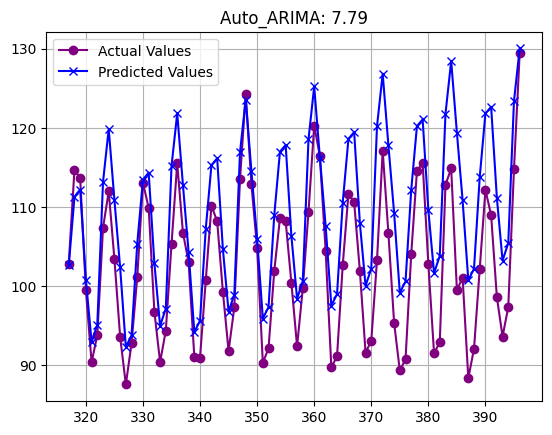

In [15]:
plt.plot(figsize=(12,6))
plt.title('Auto_ARIMA: 7.79')
plt.plot(Y['Electric_Production'], label='Actual Values', color='Purple', marker='o')
plt.plot(forecast1, label='Predicted Values', color='Blue', marker='x')
plt.legend()
plt.grid()
plt.show()

--> Training the model on the entire dataset to make future predictions (There is no way of evaluating these values as the model will be predicting future values)

In [16]:
model2 = auto_arima(data['Electric_Production'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:1

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1953.879, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2750.050, Time=0.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.34 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2401.309, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2748.185, Time=0.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.48 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.57 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1955.683, Time=3.32 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.44 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2104.339, Time=0.52 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2016.099, Time=2.71 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=3.15 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1866.557, Time=1.89 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=2265.648, Time=0.66 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1985.835, Time=1.60 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=1868.560, Time=3.19 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=1867.644, Time=3.56 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2493.118, Time=0.16 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=2179.668, Time=1.25 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=1945.380, Time=2.50 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.72 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=1872.442, Time=1.44 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1868.995, Time=1.36 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[12] intercept   : AIC=1870.846, Time=2.13 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1923.996, Time=1.04 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[12] intercept   : AIC=1870.304, Time=1.76 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=1867.470, Time=1.41 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[12] intercept   : AIC=1930.299, Time=2.06 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12]             : AIC=1863.613, Time=1.11 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12]             : AIC=2276.082, Time=0.85 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12]             : AIC=1988.820, Time=0.71 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,1)[12]             : AIC=1866.638, Time=3.10 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12]             : AIC=1864.754, Time=3.48 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12]             : AIC=2504.075, Time=0.22 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[12]             : AIC=2188.922, Time=1.51 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=1946.290, Time=1.49 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[12]             : AIC=inf, Time=5.30 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=1870.686, Time=0.60 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=1865.387, Time=0.65 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=inf, Time=1.96 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[12]             : AIC=1864.983, Time=1.03 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=1922.010, Time=0.60 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[12]             : AIC=1866.260, Time=0.79 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=1864.373, Time=0.82 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[12]             : AIC=1882.567, Time=1.68 sec

Best model:  ARIMA(1,1,2)(1,0,1)[12]          
Total fit time: 80.805 seconds


In [17]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -925.807
Date:                              Mon, 06 Jan 2025   AIC                           1863.613
Time:                                      17:03:29   BIC                           1887.502
Sample:                                           0   HQIC                          1873.077
                                              - 397                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3546      0.091      3.889      0.000       0.176       0.533
ma.L1         -0.7259      0.090     -8.082      0.000      -0.902      -0.550
ma.L2         -0.2116      0.079     -2.682      0.007      -0.366      -0.057
ar.S.L12       0.9958      0.003    307.382      0.000       0.989       1.002
ma.S.L12      -0.7616      0.038    -20.146      0.000      -0.836      -0.688
sigma2         5.7575      0.326     17.641      0.000       5.118       6.397
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                28.04
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
forecast2 = model2.predict(n_periods=12)

forecast2

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


397    114.402475
398    104.170674
399     92.102113
400     93.696980
401    104.242093
402    113.441544
403    112.385118
404    101.929526
405     93.993806
406     97.203133
407    112.233734
408    121.702223
dtype: float64

In [19]:
data

,DATE,Electric_Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [20]:
forecast2

397    114.402475
398    104.170674
399     92.102113
400     93.696980
401    104.242093
402    113.441544
403    112.385118
404    101.929526
405     93.993806
406     97.203133
407    112.233734
408    121.702223
dtype: float64

In [21]:
forecast2.values

array([114.40247486, 104.17067427,  92.10211325,  93.69697989,
       104.2420931 , 113.44154423, 112.38511793, 101.92952621,
        93.993806  ,  97.20313332, 112.23373366, 121.70222322])

In [22]:
data['DATE'] = pd.to_datetime(data['DATE'])

start_date = pd.to_datetime('2018-02-01')
end_date = pd.to_datetime('2019-01-01')

future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Values': forecast2.values
})

In [23]:
future_df

,Date,Predicted_Values
0,2018-02-01,114.402475
1,2018-03-01,104.170674
2,2018-04-01,92.102113
3,2018-05-01,93.696980
4,2018-06-01,104.242093
5,2018-07-01,113.441544
6,2018-08-01,112.385118
7,2018-09-01,101.929526
8,2018-10-01,93.993806
9,2018-11-01,97.203133


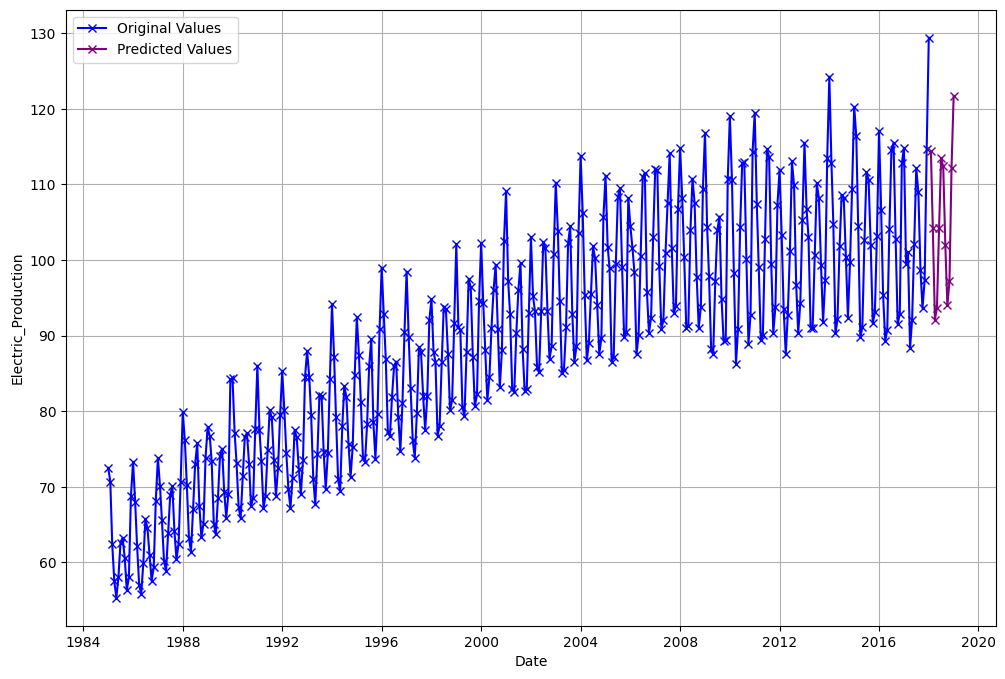

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(data['DATE'], data['Electric_Production'], label='Original Values', marker='x', color='blue')
plt.plot(future_df['Date'], future_df['Predicted_Values'], label='Predicted Values', marker='x', color='Purple')
plt.xlabel('Date')
plt.ylabel('Electric_Production')
plt.grid()
plt.legend()
plt.show()

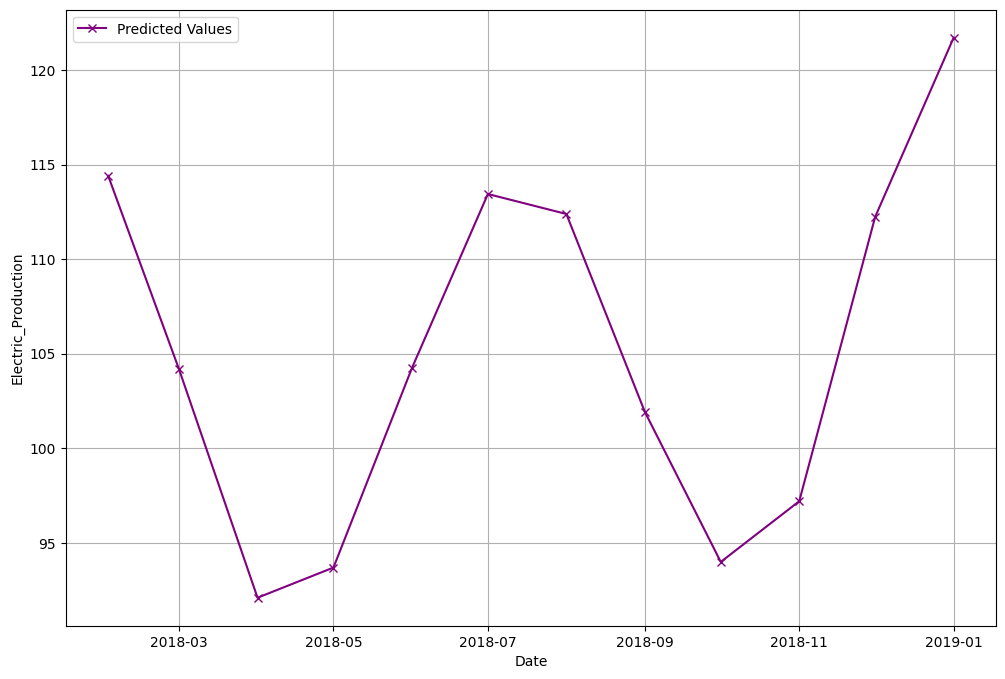

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(future_df['Date'], future_df['Predicted_Values'], label='Predicted Values', marker='x', color='Purple')
plt.xlabel('Date')
plt.ylabel('Electric_Production')
plt.grid()
plt.legend()
plt.show()